In [1]:
import tensorflow as tf
from os import path
import sys
tf.logging.set_verbosity(tf.logging.ERROR)
sys.path.append(path.join("../.."))

In [2]:
%%html
<style>
table {
    float: left;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In this example, we used two datasets of mouse brain cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Hrvatin (2018) dataset for training the neural network (NN) because it has more cells and classes, and we used the Chen (2017) dataset for testing purposes because all of its classes are present in the Hrvatin dataset.

In [3]:
EPOCHS = 35

In [4]:
%load_ext autoreload
%autoreload 2

import saly
import saly.backend as S
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
#DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
#DATA_PATH = 'D:/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [5]:
hrvatin_data, hrvatin_labels = saly.load_h5ad(DATASET_HRVATIN_PATH)
chen_data, chen_labels = saly.load_h5ad(DATASET_CHEN_PATH)

### Hrvatin

In [6]:
print(hrvatin_data.shape)
hrvatin_labels.value_counts()

(48266, 25186)


Neuron              15223
Microglia           10158
Oligodendrocyte      8630
Astrocyte            7039
Endothelial cell     3450
OPC                  1826
Pericyte              782
Muscle cell           621
Macrophage            537
Name: labels, dtype: int64

Hrvatin has 48 266 cells and 25 186 genes.

The cells are classified into 9 classes: Neuron, Oligodendrocyte, Muscle cell, Astrocyte, Endothelial cell, Macrophage, Microglia, OPC and Pericyte.

### Chen

In [7]:
print(chen_data.shape)
chen_labels.value_counts()

(14437, 23284)


Oligodendrocyte    3541
unknown            2531
Neuron             2315
OPC                1792
epithelial cell    1197
Astrocyte          1148
Microglia           724
tanycyte            609
ependymal cell      413
Macrophage          167
Name: labels, dtype: int64

Chen has 14 437 cells and 39 851 genes.

The cells are classified into 10 classes: tanycyte, Neuron, unknown, ependymal cell, Oligodendrocyte, epithelial cell, OPC, Astrocyte, Microglia and Macrophage.

# Drop rows

We removed every cell classified as 'unknown' from the Chen dataset and we also removed every cell type not found in the Hrvatin data set.

In [8]:
unseen = ['Oligodendrocyte', 'Macrophage']
hrvatin_data, hrvaatin_labels = saly.drop_rows(hrvatin_data, hrvatin_labels, unseen)

Dropped 9167 cell(s). New shape: (39099, 25186)


In [9]:
chen_unique = chen_labels.unique().to_list()
unseen_data, unseen_labels = saly.drop_rows(chen_data, chen_labels, [e for e in chen_unique if e not in unseen])

chen_data, chen_labels = saly.drop_rows(chen_data, chen_labels,
                                        ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell',
                                         'Oligodendrocyte', 'Macrophage'])

Dropped 10729 cell(s). New shape: (3708, 23284)
Dropped 8458 cell(s). New shape: (5979, 23284)


This removed 4750  cells from Chen, leaving us with 9687 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [10]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [11]:
markers = saly.get_mutual_markers([hrvatin_data.columns, chen_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [12]:
#print(len(S.get_used_markers(hrvatin_data.columns, markers_db)), len(S.get_used_markers(chen_data.columns, markers_db)))
print(len(markers))

7390


Hrvatin has 7675  markers, and Chen has 7477.

We used only those found in both datasets (7390).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [13]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes',
                'ependymal cell' : 'Ependymal cells',
                'epithelial cell' : 'Epithelial cells',
                'tanycyte' : 'Tanycytes'}

saly.check_labels([hrvatin_labels, chen_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [14]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
unseen_data = saly.drop_unused_genes(unseen_data, markers)

Dropped 21104 gene(s). New shape: (39099, 4082)
Dropped 19202 gene(s). New shape: (5979, 4082)
Dropped 19202 gene(s). New shape: (3708, 4082)


After this operation we are left with 4082 genes.

#### Make sure the data sets' shapes match

In [15]:
saly.check_shape([hrvatin_data, chen_data, unseen_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [16]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = saly.preprocess_data(hrvatin_data, hrvatin_labels,
                                                                                          train=0.7, validation=0.15,
                                                                                          test=0.15)

#### Log10 transform the Chen data, too

In [17]:
chen_data = S.log_10(chen_data)
unseen_data = S.log_10(unseen_data)

# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

For training the network we used two losses:

    1) A loss that measured the network's classification accuracy (cross entropy)
    
    2) A loss that measured the network's reconstruction accuracy (mean square error)
           During training we scaled the MSE score 100x to compensate for the losses' different scales

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4082 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4082 (genes)|

#### Create the model

In [18]:
model, marker_model, encoder_model = saly.build_model(hrvatin_data, markers, supervised=True);

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4082)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4082)              16666806  
_________________________________________________________________
cell_activations (Markers)   (None, 179)               730678    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               18000     
_________________________________________________________________
Bottleneck (Dense)           (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

# Train the model

In [20]:
history = saly.train_model(model, train_x, train_y, markers, marker_aliases,
                           EPOCHS, validation_data=(chen_data, chen_labels), verbose=1);

Train on 27369 samples, validate on 5979 samples
Epoch 1/35
27369/27369 [==============================] - 13s 460us/step - loss: 1.1871 - cell_activations_loss: 0.1026 - output_loss: 0.0108 - cell_activations_marker_prediction_metric: 0.9777 - val_loss: 1.2510 - val_cell_activations_loss: 0.1509 - val_output_loss: 0.0110 - val_cell_activations_marker_prediction_metric: 0.9809
Epoch 2/35
27369/27369 [==============================] - 10s 379us/step - loss: 0.8464 - cell_activations_loss: 0.0023 - output_loss: 0.0084 - cell_activations_marker_prediction_metric: 0.9994 - val_loss: 1.2414 - val_cell_activations_loss: 0.1488 - val_output_loss: 0.0109 - val_cell_activations_marker_prediction_metric: 0.9813
Epoch 3/35
27369/27369 [==============================] - 11s 391us/step - loss: 0.8220 - cell_activations_loss: 2.8719e-04 - output_loss: 0.0082 - cell_activations_marker_prediction_metric: 0.9999 - val_loss: 1.2329 - val_cell_activations_loss: 0.1491 - val_output_loss: 0.0108 - val_cell

27369/27369 [==============================] - 11s 396us/step - loss: 0.7507 - cell_activations_loss: 1.4339e-05 - output_loss: 0.0075 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 1.1647 - val_cell_activations_loss: 0.1130 - val_output_loss: 0.0105 - val_cell_activations_marker_prediction_metric: 0.9841
Epoch 26/35
27369/27369 [==============================] - 10s 381us/step - loss: 0.7498 - cell_activations_loss: 1.4099e-05 - output_loss: 0.0075 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 1.1651 - val_cell_activations_loss: 0.1132 - val_output_loss: 0.0105 - val_cell_activations_marker_prediction_metric: 0.9844
Epoch 27/35
27369/27369 [==============================] - 10s 376us/step - loss: 0.7497 - cell_activations_loss: 1.5072e-05 - output_loss: 0.0075 - cell_activations_marker_prediction_metric: 1.0000 - val_loss: 1.1608 - val_cell_activations_loss: 0.1120 - val_output_loss: 0.0105 - val_cell_activations_marker_prediction_metric: 0.9841
Epoc

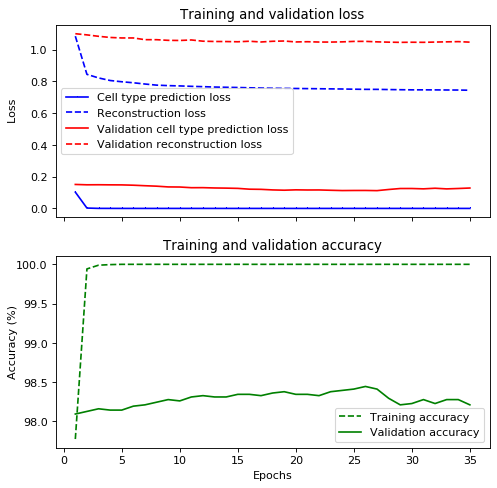

Test reconstruction loss: 0.00746062
Test prediction accuracy: 99.932 %


In [46]:
saly.plot_model_history(history, supervised=True)
saly.test_model(model, test_x, test_y, markers, marker_aliases);

# Data analysis

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('../Data/hrvatin_chen_label_colours.pickle')

## Hrvatin predictions

In [23]:
hrvatin_cell_activations = marker_model.predict(test_x)
hrvatin_bottleneck_activations = encoder_model.predict(test_x)

In [24]:
saly.get_results(test_y, hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 11722 out of 11730 (99.93%)


In [45]:
saly.get_average_auc(test_y, hrvatin_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.994


The graph below shows the mean cell type activations. Note that only one cell type explicitly activates.

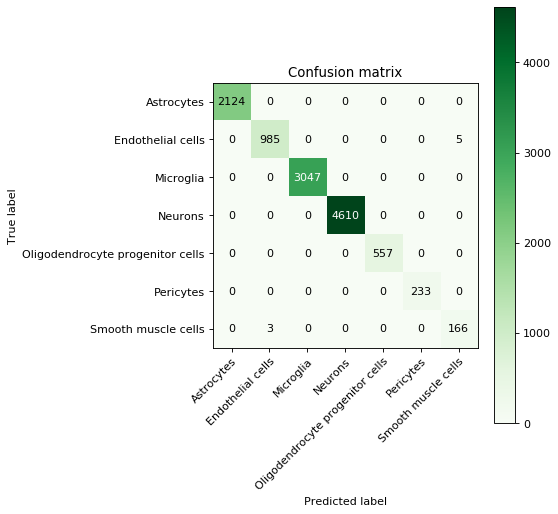

In [26]:
saly.draw_confusion_matrix(test_y, hrvatin_cell_activations, markers, marker_aliases)

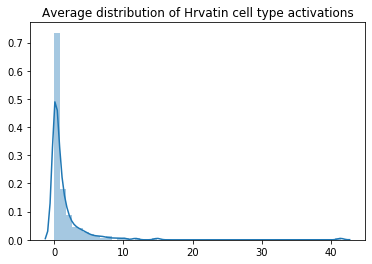

In [27]:
saly.plot_activation_distribution(hrvatin_cell_activations, markers,
                                  title='Average distribution of Hrvatin cell type activations')

## Unseen Types

In [28]:
unseen_cell_activations = marker_model.predict(unseen_data)

In [29]:
saly.get_results(unseen_labels, unseen_cell_activations, markers, marker_aliases)

Correct predictions: 0 out of 3708 (0.0%)


In [30]:
saly.get_average_auc(unseen_labels, unseen_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.5


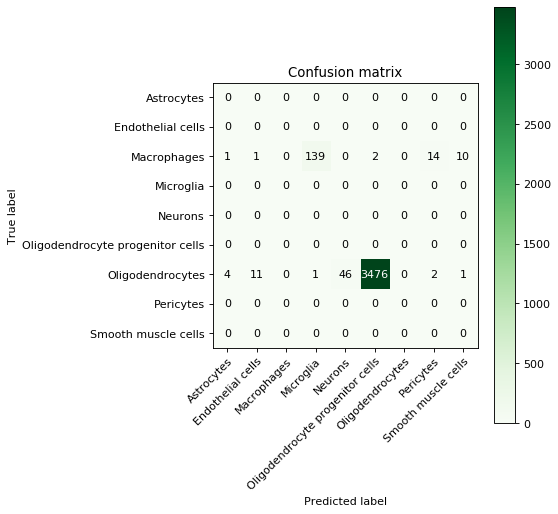

In [31]:
saly.draw_confusion_matrix(unseen_labels, unseen_cell_activations, markers, marker_aliases)

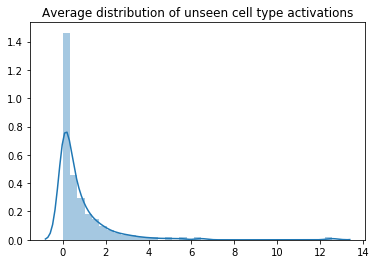

In [32]:
saly.plot_activation_distribution(unseen_cell_activations, markers,
                                  title='Average distribution of unseen cell type activations')

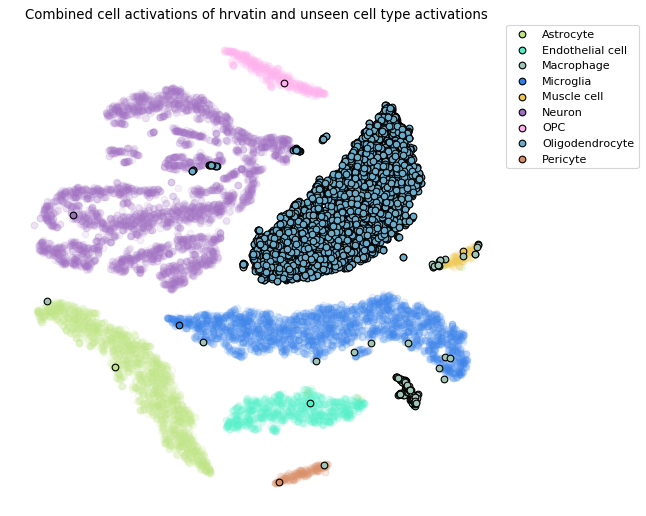

In [33]:
saly.draw_comparison([hrvatin_cell_activations, test_y], [unseen_cell_activations, unseen_labels],
                     tsne, colours=colours,
                     graph_title='Combined cell activations of hrvatin and unseen cell type activations')

## Chen predictions

In [33]:
chen_cell_activations = marker_model.predict(chen_data)

In [34]:
saly.get_results(chen_labels, chen_cell_activations, markers, marker_aliases)

Correct predictions: 5872 out of 5979 (98.21%)


In [35]:
saly.get_average_auc(chen_labels, chen_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.884


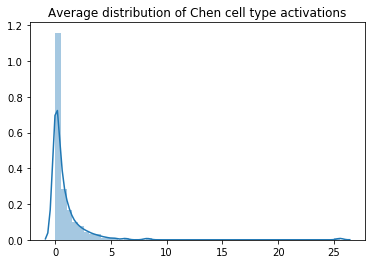

In [36]:
saly.plot_activation_distribution(chen_cell_activations, markers,
                                  title='Average distribution of Chen cell type activations')

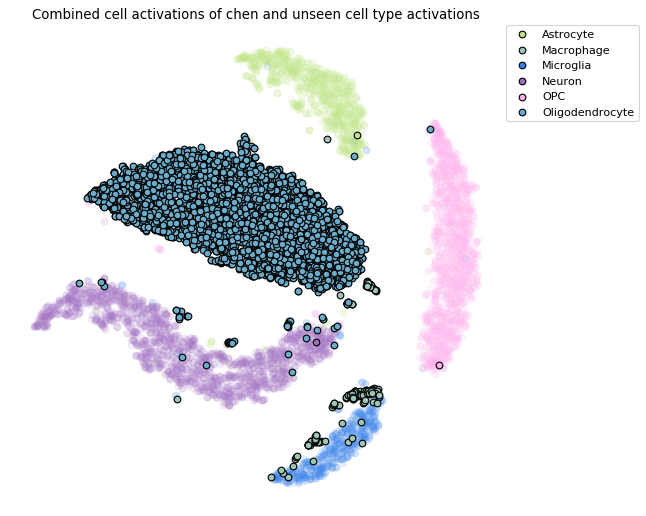

In [38]:
saly.draw_comparison([chen_cell_activations, chen_labels], [unseen_cell_activations, unseen_labels],
                     tsne, colours=colours,
                     graph_title='Combined cell activations of chen and unseen cell type activations')

# Reconstruction

In [37]:
reconstruction = model.predict(chen_data)[1]
reconstruction = pd.DataFrame(reconstruction, columns=chen_data.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

In [38]:
saly.get_results(chen_labels, reconstructed_cell_activations, markers, marker_aliases)

Correct predictions: 5886 out of 5979 (98.44%)


In [39]:
saly.get_average_auc(chen_labels, reconstructed_cell_activations, markers, marker_aliases)

Average ROC AUC: 0.984


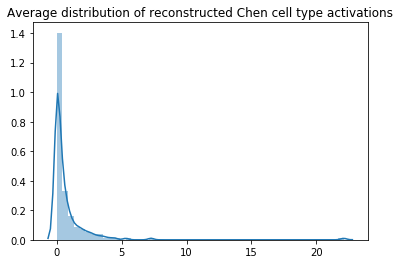

In [40]:
saly.plot_activation_distribution(reconstructed_cell_activations, markers,
                                  title='Average distribution of reconstructed Chen cell type activations')


# Reconstruction of Unseen Cells

In [41]:
reconstructed_unseen = model.predict(unseen_data)[1]
reconstructed_unseen = pd.DataFrame(reconstructed_unseen, columns=unseen_data.columns)
reconstructed_unseen_activation = marker_model.predict(reconstructed_unseen)

In [42]:
saly.get_results(unseen_labels, reconstructed_unseen_activation, markers, marker_aliases)

Correct predictions: 0 out of 3708 (0.0%)


In [43]:
saly.get_average_auc(unseen_labels, reconstructed_unseen_activation, markers, marker_aliases)

Average ROC AUC: 0.513


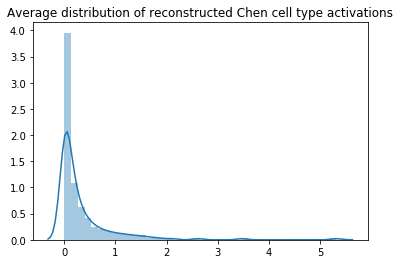

In [44]:
saly.plot_activation_distribution(reconstructed_unseen_activation, markers,
                                  title='Average distribution of reconstructed Chen cell type activations')